# 1D CNN for 12-Lead ECG Classification

**Main Thesis Topic:** “Zero-shot classification of ECG signals using CLIP-like model”. 

**For example:** Train on PBT-XL: 

- **Text Encoder:** ClinicalBERT
- **Image Encoder:** 1D CNN

**Experiment A):** Baseline: We can take only the name of the class. For example, take “Myocardial Infarction” as a text. We should exclude some classes from training and after training is completed, the CLIP-like model can be tested on these excluded classes. 
Next, we get embeddings of text from biobert and train ECG encoder with contrastive loss.

**Experiment B):** Same as Experiment A but instead of testing on the same dataset/classes, we would test on other datasets containing different classes.

**Evaluation metrics:** 
- Main: AUC-ROC, average_precison_score, 
- Optional: Specificity, Sensitivity, F1-score 

Outcome: 

It’s possible to train CLIP-like models with freezed (or unchanged/not fine tuned for downstream tasks) text encoder
Training ECG encoders that are viable for representing different domains (within ECG modality) and previously unseen classes. 
Training a CLIP-like model on ECGs has little novelty.

https://www.baeldung.com/cs/contrastive-learning

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys

# Evaluation Metrics
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
sys.path.append('C:/Users/navme/Desktop/ECG_Project/PyFiles')

In [3]:
# Import helper functions
import helper_functions as hf
import helper_function_tests as hft
from dataset import PhysioNetDataset

In [4]:
PhysioNet_PATH = f'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'
PhysioNet_PATH

'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'

In [5]:
train_set = PhysioNetDataset(PhysioNet_PATH, train = True)
test_set = PhysioNetDataset(PhysioNet_PATH, train = False)

print("There are {0} datasets in the train_set and {1} datasets in the test_set".format(len(train_set), len(test_set)))

There are 7 datasets in the train_set and 2 datasets in the test_set


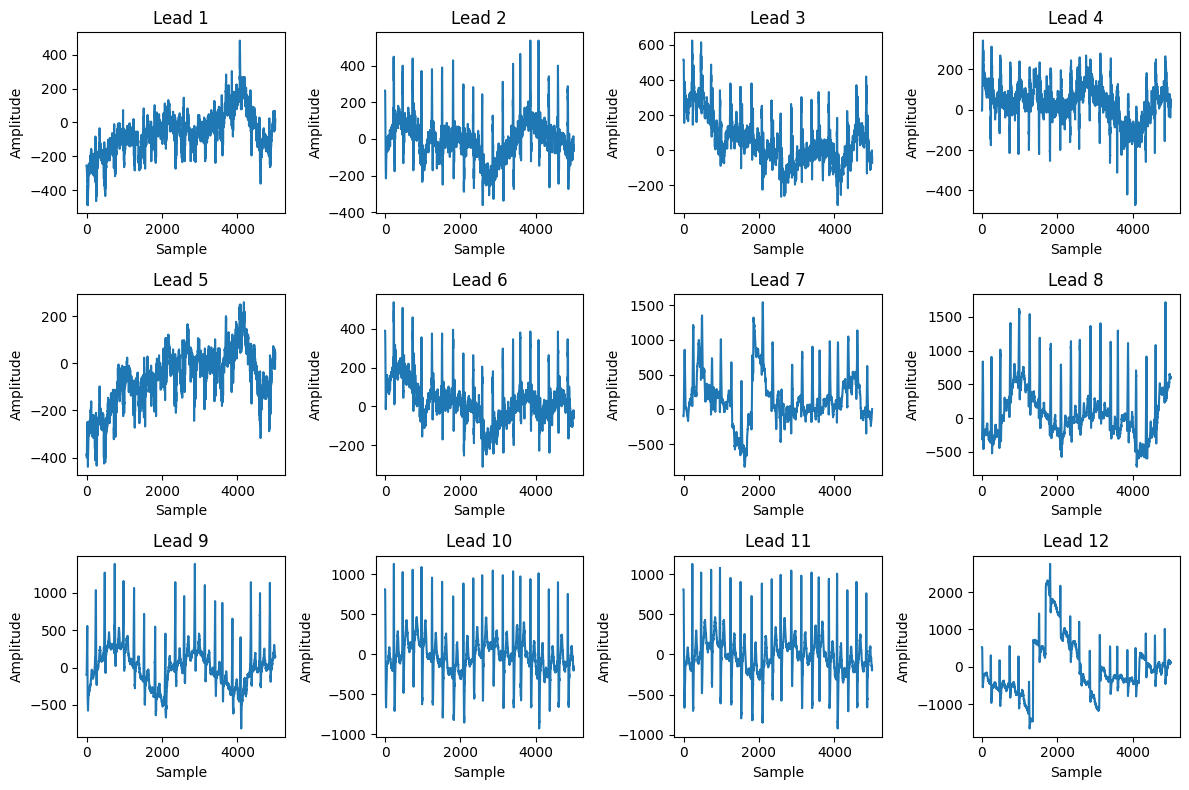

In [6]:
train_set.plot_record(0)

## SNOWMED-CT Codes

## Contrastive Loss

In [63]:
class TripletLoss(torch.nn.Module):
    """
    Triplet loss function.
    Based on: 
        - L = max(0, ||x - x+||^2 - ||x - x-||^2 + m) (text)
        - L = max(0, \left \| x - x^+ \right \|^2 - \left \| x - x^- \right \|^2 + m) (LaTex)

        Args:
            - ||.|| denotes the Euclidean distance between two vectors
            - x is the anchor point input
            - x+ is the positive point input
            - x- is the negative point input
            - m is the margin (hyperparameter)

    - The goal of the loss function is to encourage the distance between the anchor point and the positive point to be smaller 
      than the distance between the anchor point and the negative point by a margin m.

    - When the distance between the anchor and positive points is not smaller than the distance between the anchor and negative points by 
      at least the margin m, the loss function is positive and encourages the model to adjust its parameters to decrease 
      the distance between the anchor and positive points and/or increase the distance between the anchor and negative points.
    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = F.pairwise_distance(anchor, positive, keepdim=True)
        negative_distance = F.pairwise_distance(anchor, negative, keepdim=True)

        triplet_loss = torch.mean(torch.clamp(positive_distance - negative_distance + self.margin, min=0.0))

        return triplet_loss

In [78]:
def test_triplet_loss():

    # Create some random input tensors
    anchor = torch.randn(4, 20)
    positive = torch.randn(4, 20)
    negative = torch.randn(4, 20)

    # Create an instance of the TripletLoss class
    triplet_loss = TripletLoss(margin=1.0)

    # Compute the loss using the forward method of the TripletLoss class
    loss = triplet_loss(anchor, positive, negative)
    print(loss)

    # Compute the expected loss using the formula for the Triplet Loss
    expected_loss = torch.mean(torch.clamp(F.pairwise_distance(anchor, positive, keepdim=True) - F.pairwise_distance(anchor, negative, keepdim=True) + 1.0, min=0.0))
    print(expected_loss)

    # Check that the computed loss is equal to the expected loss
    assert torch.allclose(loss, expected_loss)
    print(torch.allclose(loss, expected_loss))

In [97]:
test_triplet_loss()

tensor(1.2849)
tensor(1.2849)
True


## Model

In [7]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [108]:
class OneDimCNN(nn.Module):
    def __init__(self, num_classes):
        super(OneDimCNN, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Layer 4
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(64)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully Connected Layer 1
        self.fc1 = nn.Linear(64*3, num_classes)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        # Fully Connected Layer 2
        self.fc2 = nn.Linear(num_classes, num_classes)
        self.triplet_loss = TripletLoss(margin=1.0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x1, x2=None, x3=None):
        if x2 is None and x3 is None:
            # Layer 1
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu1(x)
            x = self.pool1(x)

            # Layer 2
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu2(x)
            x = self.pool2(x)

            # Layer 3
            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu3(x)
            x = self.pool3(x)

            # Layer 4
            x = self.conv4(x)
            x = self.bn4(x)
            x = self.relu4(x)
            x = self.pool4(x)

            # Flatten
            x = x.reshape(x.size(0), -1)

            # Fully Connected Layer 1
            x = self.fc1(x)
            x = self.relu5(x)
            x = self.dropout1(x)

            # Fully Connected Layer 2
            x = self.fc2(x)

            return x

        else:
            output1 = self.forward(x1)
            output2 = self.forward(x2)
            output3 = self.forward(x3)
            
            loss = self.triplet_loss(output1, output2, output3)

            return loss
            

In [109]:
model = OneDimCNN(num_classes=75)
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters: ", num_params)

Number of parameters:  151343
